![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import re

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
sns.set()

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

In [9]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# DATA

Загрузим датасеты. Добавим дополнительно
* датасет по крупным городам с информацией о численности их населения, является ли город столицей и т.д.,
* файл со словами, которые могут быть включены в положительные отзывыю

In [10]:
df_train = pd.read_csv('data/main_task.csv', converters={"Cuisine Style": lambda x: x[1:-1].split(',')})
df_test = pd.read_csv('data/kaggle_task.csv', converters={"Cuisine Style": lambda x: x[1:-1].split(',')})
sample_submission = pd.read_csv('data/sample_submission.csv')
# additional files
cities = pd.read_csv('data/world_cities_dataset.csv')
positive_words = []
with open('data/positive_words.txt', 'r') as file:
    for word in file.readlines():
        positive_words.append(word.strip())

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      40000 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [12]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,[],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'V...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,[],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian F...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      10000 non-null  object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [14]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Op...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'V...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'S...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [15]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [16]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [17]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [19]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
34963,id_3074,Prague,['Chinese'],3081.0,NaN,4.0,[['This is more a take away with tables than.....,/Restaurant_Review-g274707-d7099676-Reviews-Di...,d7099676,1,4.0
1493,id_1493,Rome,"['Steakhouse', 'Mediterranean', 'Italian', ...",188.0,$$ - $$$,982.0,"[['Going Gently into a Good Night', 'Amazing!'...",/Restaurant_Review-g187791-d7097365-Reviews-I_...,d7097365,0,0.0
35544,id_8866,London,[],8875.0,NaN,2.0,"[['Proper porridge, great cakes', 'Excellent, ...",/Restaurant_Review-g186338-d8743387-Reviews-Ho...,d8743387,1,5.0
1303,id_1303,Munich,"['Italian', 'Pizza', 'Mediterranean', 'Euro...",611.0,$,179.0,"[['Good value', 'Good food'], ['04/08/2017', '...",/Restaurant_Review-g187309-d2189257-Reviews-Pi...,d2189257,0,0.0
38919,id_777,Lyon,['French'],778.0,$$ - $$$,32.0,"[['Tasty food and nice stuff'], ['09/14/2016']]",/Restaurant_Review-g187265-d7613240-Reviews-Le...,d7613240,1,4.5


In [20]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

# Обработка признаков
Пройдемся по всем доступным признакам, проведем предварительную обработку, заполним пропуски и обработаем выбросы, если они есть, и создадим новые признаки на базе имеющихся.

## Price Range column

Заменим строковые значения на числовые от 0 до 2 по возрастанию цены. В таком случае получим категориальные порядковые данные.

In [21]:
price_range_conv = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
data['Price_Range_Cat'] = data['Price Range'].map(price_range_conv)

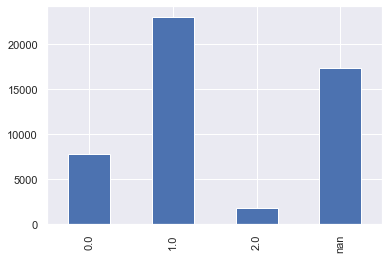

In [22]:
data.Price_Range_Cat.value_counts(dropna=False).sort_index().plot(kind='bar');

Глядя на распределение значение по ценовому сегменту ресторана, можно предположить, что создание нового бинарного признака, как среднеценовой ресторан, может улучшить качество модели.

In [23]:
data['Middle_Price_Restaurant'] = data['Price_Range_Cat'].apply(lambda x: 1 if x==1 else 0)

## City column

In [24]:
def feature_eng_cities(unique_cities):
    """Для всех городов из входящего массива данных создает и возращает словарь данных, где для каждого города (ключа) содержиться следующая информация: 
     - страна, 
     - является ли город столицей, 
     - является ли город административным центром, 
     - численность населения города."""
    cities_dict = {}
    for city in unique_cities:
        if city == 'Oporto':
            city = 'Porto'
        data = cities[cities.city_ascii == city].sort_values('population', ascending=False)
        if city == 'Porto':
            city = 'Oporto'
        cities_dict[city] = []
        cities_dict[city].append(data.country.values[0])
        cities_dict[city].append(1 if data.capital.values[0] == 'primary' else 0)
        cities_dict[city].append(1 if data.capital.values[0] == 'admin' else 0)
        cities_dict[city].append(data.population.values[0])
    return cities_dict

Из стороннего датасета извлекаем дополнительную информацию по каждому городу.

In [25]:
cities_dict = feature_eng_cities(data.City.unique().tolist())
cities_info = data['City'].map(cities_dict).apply(pd.Series)
cities_info.columns = ['Country', 'Capital', 'Admin', 'Population']

data = pd.concat([data, cities_info], axis=1)

In [26]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Price_Range_Cat,Middle_Price_Restaurant,Country,Capital,Admin,Population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1.0,1,France,1,0,11020000.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Op...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,1,Finland,1,0,642045.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1.0,1,United Kingdom,0,0,488050.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'V...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,2.0,0,United Kingdom,1,0,10979000.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'S...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,2.0,0,Slovakia,1,0,429564.0


## Cuisine column

Посчитаем, сколько кухонь представлено в каждом ресторане

In [27]:
data['Cuisine_Style_Count'] = data['Cuisine Style'].apply(lambda x: len(x) if not isinstance(x, float) else 1)

Создадим dummy переменные для все уникальных кухонь в датасете (не улучшило результат отправки)

In [28]:
# unique_cuisines = [cuisine.replace("'", '').strip() for cuisine in data.explode('Cuisine Style')['Cuisine Style'].unique()]
# for unique_cuisine in unique_cuisines:
#     data[unique_cuisine] = data['Cuisine Style'].apply(lambda x: 1 if unique_cuisine in x else 0)

## Reviews column

In [29]:
def extract_reg(string, reg):
    "Находит заданное регулярное выражение в искомой строке и возвращает все найденные результаты в виде массива."
    results = re.findall(reg, string)
    return results

def calculate_dates(dates):
    "Вычисляет число дней между первый и последним оставленным отзывов в ресторане."
    if dates:
        dates_conv = pd.to_datetime(dates).sort_values()
        return (dates_conv[-1] - dates_conv[0]).days
    else:
        return None
    
def calculate_perc_posit_reviews(reviews):
    "Используя лист слов, несущих позитивный оттенок, вычисляет процент позитивных отзывов для ресторана."
    if reviews:
        count = 0
        for rev in reviews:
            if any([word in rev.lower() for word in positive_words]):
                count += 1
        return count / len(reviews)
    else:
        return None
    
def is_posit_reviews(reviews):
    "Используя лист слов, несущих позитивный оттенок, определяет есть ли позитивные отзывы у ресторана."
    if reviews:
        count = 0
        for rev in reviews:
            if any([word in rev.lower() for word in positive_words]):
                count += 1
        if count > 0:
            return 1
        else: 
            return 0
    else: 
        return None

Для того, чтобы применить последующий анализ, заменим пустые значения на значение 'Other'.

In [30]:
data.Reviews = data.Reviews.fillna('[Other]')

Вначале отделим даты всех имеющихся отзывов для всех ресторанов в отдельный столбец, а затем добавим новые признаки по количеству оставленных отзывов и разницей в днях между первым и последним оставленным отзывом для ресторана.

In [31]:
data['Reviews_dates'] = data.Reviews.apply(lambda x: extract_reg(x, r'\d{2}\/\d{2}\/\d{4}'))
data['Reviews_Count'] = data.Reviews_dates.apply(len)
data['Reviews_Dates_Max_Diff'] = data.Reviews_dates.apply(calculate_dates)

Сохраним текст всех имеющихся отзывов для всех ресторанов в отдельный столбец, а затем добавим новые признаки, включающих процент позитивных отзывов и наличие в целом позитивных отзывов для ресторана.

In [32]:
data['Reviews_text'] = data.Reviews.apply(lambda x: extract_reg(x, r"\['([\D]+)'\]"))
data['Pos_Perc_Reviews'] = data.Reviews_text.apply(calculate_perc_posit_reviews)
data['Is_Pos_Reviews'] = data.Reviews_text.apply(is_posit_reviews)

Посчитаем количество ресторанов в каждом городе и применим этот признак, чтобы определить относительный рейтинг ресторана в каждом городе.

In [33]:
restorants_in_city = dict(data.groupby('City')['Ranking'].count())
data['Restaurants_Count'] = data['City'].map(restorants_in_city)
data['Ranking_Rel'] = data.Ranking / data.Restaurants_Count

Посчитаем количество ресторанов на душу населения в городе.

In [34]:
data['Restaurants_Count_per_Person'] = data.Population / data.Restaurants_Count

### Найдем в каких столбцах присутствуют пропущенные значения и заменим их на моду для категориальных и на среднее для числовых по каждому городу отдельно.

Для категориального столбца Price_Range_Cat заменим пропущенные значения на моду по городу.

In [35]:
city_range_cat = dict(data.groupby('City').Price_Range_Cat.agg(pd.Series.mode))
data.Price_Range_Cat = data.Price_Range_Cat.fillna(data.City.map(city_range_cat))

Для оставшихся числовых столбцов заменим пропущенные значения на среднее значение по городу.

In [36]:
def fill_na_mean_for_city(data, col):
    dict_cat = dict(round(data.groupby('City')[col].mean(), 0))
    return data[col].fillna(data.City.map(dict_cat))

data['Number of Reviews'] = fill_na_mean_for_city(data, 'Number of Reviews')
data.Reviews_Dates_Max_Diff = fill_na_mean_for_city(data, 'Reviews_Dates_Max_Diff')
data.Pos_Perc_Reviews = fill_na_mean_for_city(data, 'Pos_Perc_Reviews')
data.Is_Pos_Reviews = fill_na_mean_for_city(data, 'Is_Pos_Reviews')

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

Создадим dummy переменные для оставшихся строковых признаков.

In [37]:
data = pd.get_dummies(data, columns=['City', 'Country'], drop_first=True)

Удалим ненужные признаки или признаки, которые ухудшали модель.

In [38]:
data = data.drop(['Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'Restaurant_id', 'Reviews_dates', 'Reviews_text'], axis=1)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение ресторанов по городам

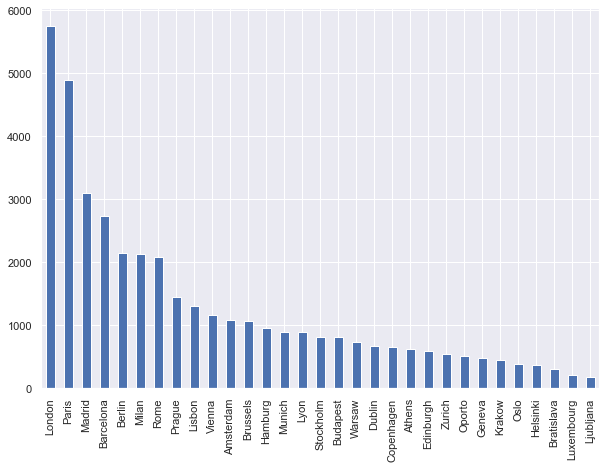

In [39]:
plt.figure(figsize=(10,7))
df_train['City'].value_counts(ascending=False).plot(kind='bar');

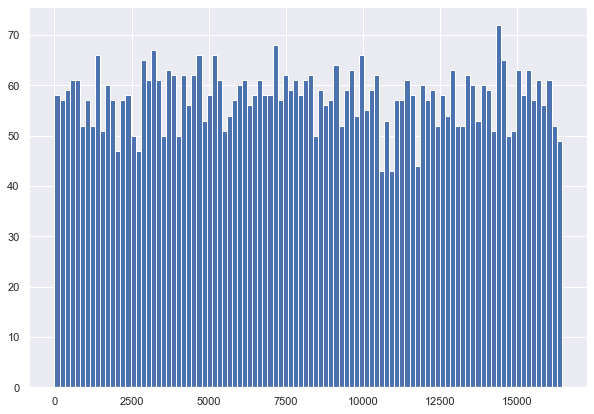

In [40]:
plt.figure(figsize=(10,7))
df_train[df_train['City'] =='London']['Ranking'].hist(bins=100);

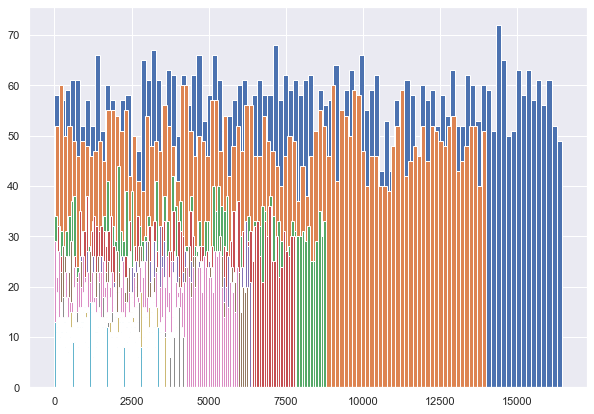

In [41]:
# посмотрим на топ 10 городов
plt.figure(figsize=(10,7))
for x in (df_train['City'].value_counts()).index[0:10]:
    df_train[df_train['City'] == x]['Ranking'].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

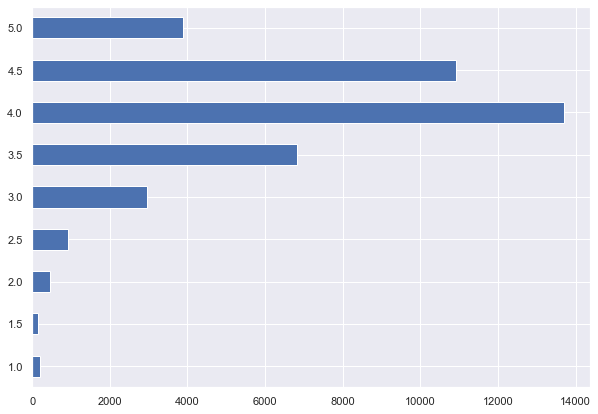

In [42]:
plt.figure(figsize=(10,7))
df_train['Rating'].value_counts().sort_index().plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака

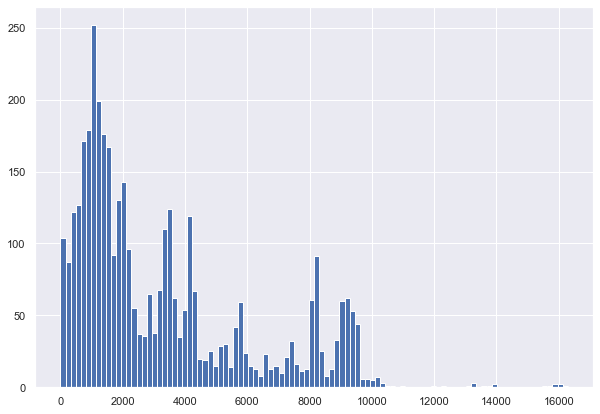

In [43]:
plt.figure(figsize=(10,7))
df_train[df_train['Rating'] == 5]['Ranking'].hist(bins=100);

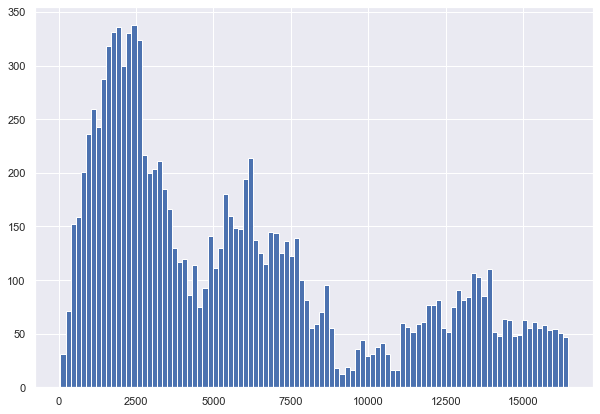

In [44]:
plt.figure(figsize=(10,7))
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100);

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

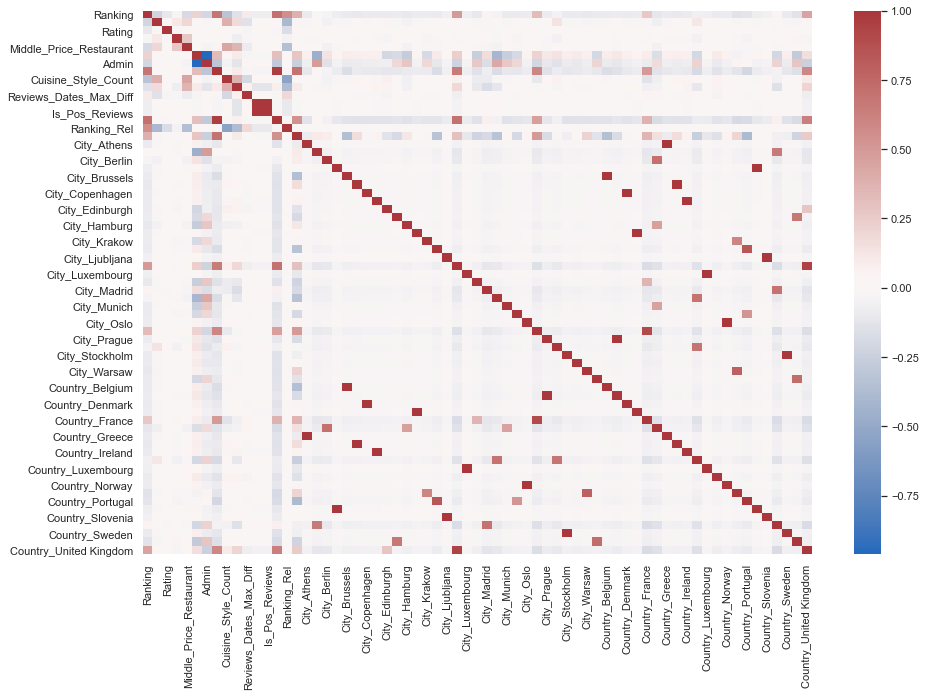

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(data.drop(['sample'], axis=1).corr(), cmap='vlag');

In [46]:
data.corr().Rating.sort_values(ascending=False).to_frame()

,Rating
Rating,1.000000
sample,0.936543
Pos_Perc_Reviews,0.035189
Is_Pos_Reviews,0.035189
Cuisine_Style_Count,0.034506
...,...
City_Madrid,-0.016232
City_Milan,-0.023233
Reviews_Dates_Max_Diff,-0.029755
Ranking,-0.109897


Мы видим, что не наблюдается высокой положительной и отрицательной корреляции между признаками и с целевой переменной. В этом случае мы можем использовать данные для тренировки модели.

In [47]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [48]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 67), (40000, 67), (40000, 66), (32000, 66), (8000, 66))

# Model 
Сам ML

In [50]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [51]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [52]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [53]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20685812499999998


<AxesSubplot:>

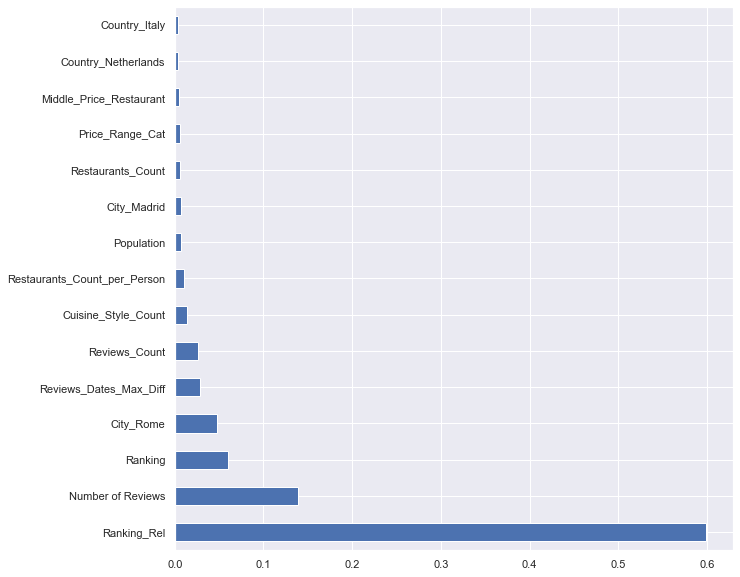

In [54]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [55]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Price_Range_Cat,Middle_Price_Restaurant,Capital,Admin,Population,Cuisine_Style_Count,Reviews_Count,...,Country_Netherlands,Country_Norway,Country_Poland,Country_Portugal,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom
1666,34.0,375.0,0.0,2.0,0,1,0,1790658.0,5,2,...,0,0,1,0,0,0,0,0,0,0
5019,4048.0,35.0,0.0,1.0,1,1,0,2872800.0,1,2,...,0,0,0,0,0,0,0,0,0,0
2387,1277.0,3.0,0.0,1.0,0,0,0,488050.0,1,2,...,0,0,0,0,0,0,0,0,0,1
5744,1545.0,224.0,0.0,1.0,1,0,1,4588000.0,3,2,...,0,0,0,0,0,0,1,0,0,0
3540,1969.0,13.0,0.0,1.0,1,1,0,1840573.0,4,2,...,0,0,0,0,0,0,0,0,0,0
4192,7965.0,14.0,0.0,1.0,1,1,0,10979000.0,3,2,...,0,0,0,0,0,0,0,0,0,1
3243,2393.0,8.0,0.0,1.0,0,1,0,1840573.0,1,2,...,0,0,0,0,0,0,0,0,0,0
755,13315.0,3.0,0.0,1.0,0,1,0,10979000.0,1,2,...,0,0,0,0,0,0,0,0,0,1
2790,6013.0,5.0,0.0,1.0,0,0,1,1351562.0,1,0,...,0,0,0,0,0,0,0,0,0,0
7368,2517.0,644.0,0.0,2.0,0,1,0,10979000.0,3,2,...,0,0,0,0,0,0,0,0,0,1


In [56]:
test_data = test_data.drop(['Rating'], axis=1)

In [57]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [58]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [59]:
predict_submission

array([3.11 , 4.265, 4.505, ..., 3.07 , 4.495, 4.3  ])

In [60]:
#округляем до 0.5
predict_submission =  (predict_submission * 2).round(0) / 2
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [61]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
